In [71]:
# Deps
import os
import os.path as path

import wandb
import pickle

import numpy as np
import pandas as pd

# Plotting related
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set(style="darkgrid") # Styling

In [72]:
# Configuration:
## Set the WANDB entity and project name to be used
wandb_entity_project = "dosssman/drlforge.ddpg"

# Cache dir structure
cache_dir = wandb_entity_project.replace("/","_").replace("-", "_").replace(".","_") # Make it simple folder name
cache_dir += "_noise_type"

if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Episode reward cached data
all_env_cache_filename = os.path.join( cache_dir, "all_envs.pkl")
all_df_cache_filename = os.path.join( cache_dir, "all_df.pkl")

In [73]:
# DDPG: Data loading for Train Episode Return Plots.
api = wandb.Api()

runs = api.runs(wandb_entity_project)
summary_list = [] 
config_list = [] 
name_list = []
envs = {}
data = []
rolling_average = 10
sample_points = 500

if not path.exists(all_env_cache_filename) or not path.exists(all_df_cache_filename):
    print( "# Info: No cache found. Downloading data ...")
    # Loading full data in case no cached is found
    for idx, run in enumerate(runs):
        ls = run.history(keys=['eval/train_episode_return', 'global_step'], pandas=False)
        metrics_dataframe = pd.DataFrame(ls[0])
        metrics_dataframe.insert(len(metrics_dataframe.columns), "algo", run.config['exp_name'] + "_" + run.config["noise_type"])
        metrics_dataframe.insert(len(metrics_dataframe.columns), "seed", run.config['seed'])
#         metrics_dataframe.insert(len(metrics_dataframe.columns), "noise_type", run.config['noise_type'])
        data += [metrics_dataframe]
        if run.config["env_id"] not in envs:
            envs[run.config["env_id"]] = [metrics_dataframe]
            envs[run.config["env_id"]+"total_steps"] = run.config["total_steps"]
        else:
            envs[run.config["env_id"]] += [metrics_dataframe]

        # run.summary are the output key/values like accuracy.  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict) 

        # run.config is the input metrics.  We remove special values that start with _.
        config_list.append({k:v for k,v in run.config.items() if not k.startswith('_')}) 

        # run.name is the name of the run.
        name_list.append(run.name)       

    summary_df = pd.DataFrame.from_records(summary_list)
    config_df = pd.DataFrame.from_records(config_list) 
    name_df = pd.DataFrame({'name': name_list}) 
    all_df = pd.concat([name_df, config_df,summary_df], axis=1)
    data = pd.concat(data, ignore_index=True)
    
    # Smoothing
    rolling_average = 20
    for env in envs:
        if not env.endswith("total_steps"):
            for idx, metrics_dataframe in enumerate(envs[env]):
                envs[env][idx] = metrics_dataframe.dropna(subset=["eval/train_episode_return"])
                envs[env][idx]["eval/train_episode_return"] = metrics_dataframe["eval/train_episode_return"].rolling(rolling_average).mean()[rolling_average:]
    
    with open(all_df_cache_filename, 'wb') as handle:
        pickle.dump(all_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(all_env_cache_filename, 'wb') as handle:
        pickle.dump(envs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print( "# Info: Data loaded and cached.")
else:
    with open(all_df_cache_filename, 'rb') as handle:
        all_df = pickle.load(handle)
    with open(all_env_cache_filename, 'rb') as handle:
        envs = pickle.load(handle)
    print( "# Info: Data loaded from cache.")

# Info: No cache found. Downloading data ...
# Info: Data loaded and cached.


In [74]:
# Helper: Get Dataframe of the Episode reward given the environment
# TODO: Implement caching
def get_df_for_env(env_id):
    env_total_steps = envs[env_id+"total_steps"]
    env_increment = env_total_steps / 500
    envs_same_x_axis = []
    for sampled_run in envs[env_id]:
        df = pd.DataFrame(columns=sampled_run.columns)
        x_axis = [i*env_increment for i in range(500-2)]
        current_row = 0
        for timestep in x_axis:
            while sampled_run.iloc[current_row]["global_step"] < timestep:
                current_row += 1
                if current_row > len(sampled_run)-2:
                    break
            if current_row > len(sampled_run)-2:
                break
            temp_row = sampled_run.iloc[current_row].copy()
            temp_row["global_step"] = timestep
            df = df.append(temp_row)
        
        envs_same_x_axis += [df]
    return pd.concat(envs_same_x_axis, ignore_index=True)\

# Caching data for all environments all at once
ALL_ENVS = list(sorted(set(all_df["env_id"])))
ALL_ENV_EPISODE_RETURN_DF = {}

ep_return_cachedir = os.path.join( cache_dir, "episode_return")
if not path.exists( ep_return_cachedir):
    os.makedirs(ep_return_cachedir)

for env_name in ALL_ENVS:
    print( f"# INFO: Fetching / Loading data for {env_name}")
    
    env_ep_return_cachefile = os.path.join( ep_return_cachedir, f"{env_name}_cache.pkl")
    if not path.exists(env_ep_return_cachefile):
        print("#  Cached data not found, reading runs data from WANDB")
        # Actually process the data. Takes most of the time.
        env_df = get_df_for_env(env_name)
        
        with open(env_ep_return_cachefile, 'wb') as handle:
            pickle.dump(env_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        # Load it from cached data
        print("#  Cached data found and loaded")
        with open(env_ep_return_cachefile, 'rb') as handle:
            env_df = pickle.load(handle)
    
    # Add the data to global variable for later usage
    ALL_ENV_EPISODE_RETURN_DF[f"{env_name}"] = env_df

print( "# INFO: All data loading done for episode reward data")

# INFO: Fetching / Loading data for Ant-v2
#  Cached data not found, reading runs data from WANDB
# INFO: Fetching / Loading data for AntBulletEnv-v0
#  Cached data not found, reading runs data from WANDB
# INFO: Fetching / Loading data for HalfCheetah-v2
#  Cached data not found, reading runs data from WANDB
# INFO: Fetching / Loading data for HalfCheetahBulletEnv-v0
#  Cached data not found, reading runs data from WANDB
# INFO: Fetching / Loading data for Hopper-v2
#  Cached data not found, reading runs data from WANDB
# INFO: Fetching / Loading data for HopperBulletEnv-v0
#  Cached data not found, reading runs data from WANDB
# INFO: Fetching / Loading data for Humanoid-v2
#  Cached data not found, reading runs data from WANDB
# INFO: Fetching / Loading data for HumanoidBulletEnv-v0
#  Cached data not found, reading runs data from WANDB
# INFO: Fetching / Loading data for LunarLanderContinuous-v2
#  Cached data not found, reading runs data from WANDB
# INFO: Fetching / Loading data 

In [75]:
# Plot for one environment
env_name = "MountainCarContinuous-v0"

# Get the dataframe
env_df = ALL_ENV_EPISODE_RETURN_DF[env_name]

In [76]:
set(env_df["algo"])
label_to_readable = { "ddpg_ou": "DDPG Orhnstein-Ulhenbeck", "ddpg_adapt-param": "DDPG Adpat. Param.", "ddpg_normal": "DDPG Normal Noise"}
exp_names = ["ddpg_ou","ddpg_adapt-param", "ddpg_normal"]
current_palette = sns.color_palette(n_colors=3) # TODO: Change palette to match the WANDB logs ?
current_palette = np.array([
    [240,184,153],
    [34,148,135],
    [83,135,221]
]) / 255.
current_palette_dict = dict(zip(exp_names, current_palette))
# current_palette

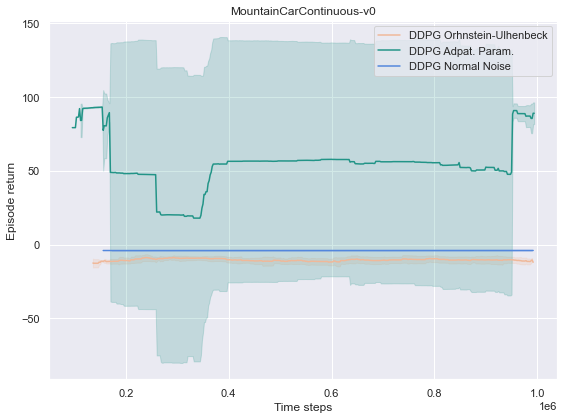

In [77]:
# Plot parameterization
fig, ax = plt.subplots(figsize=(8,6))

# Plot the data onto the ax object
sns.lineplot(data=env_df,
    x="global_step",
    y="eval/train_episode_return",
    ci='sd', ax=ax, hue="algo",
    palette=current_palette_dict
)
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles[1:], labels=labels[1:])
labels = [label_to_readable[label] for label in labels[1:]]
    
# Plot config and pretify
ax.set_title(env_name)
ax.set_xlabel("Time steps")
ax.set_ylabel("Episode return")
ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
ax.legend(handles[1:], labels)

plt.tight_layout()
plt.show()

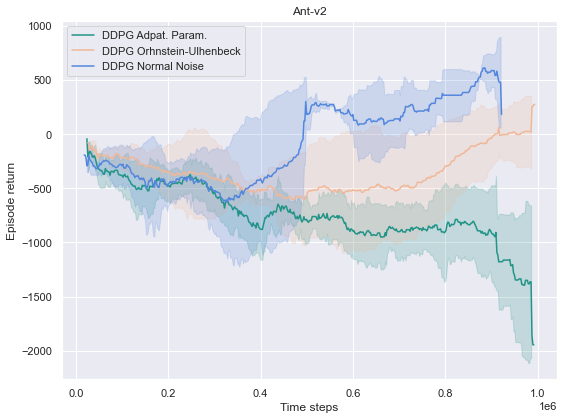

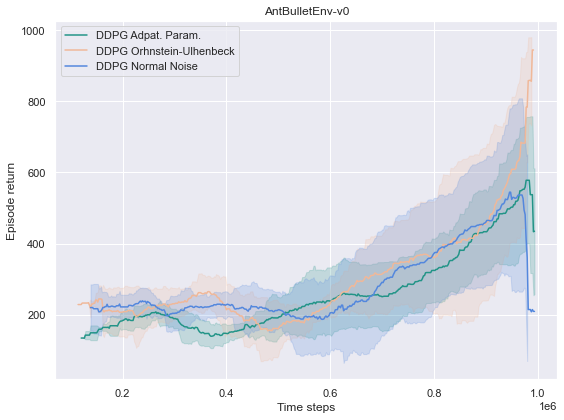

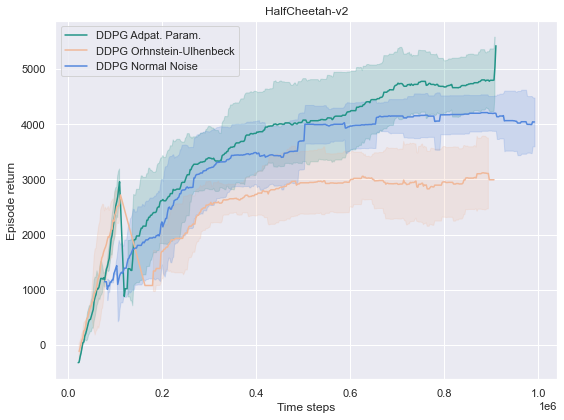

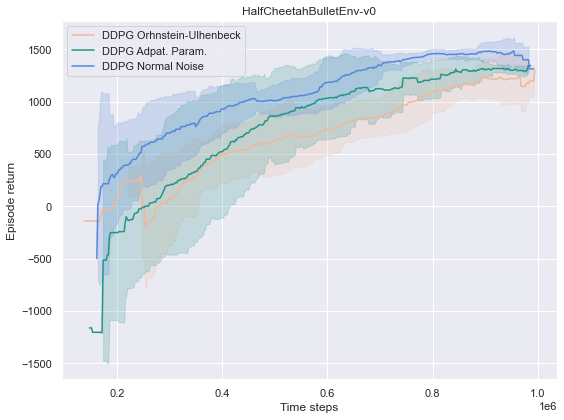

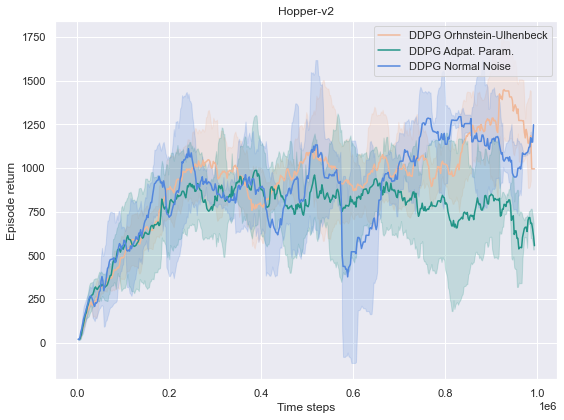

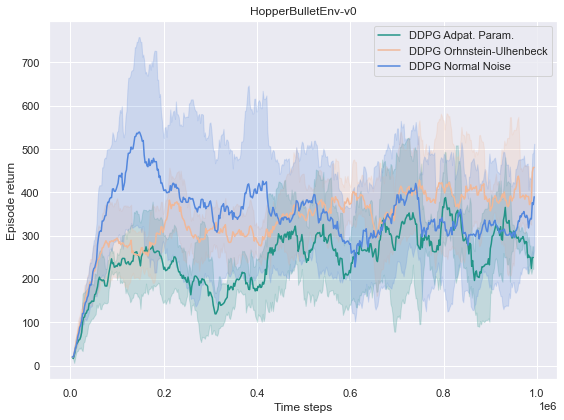

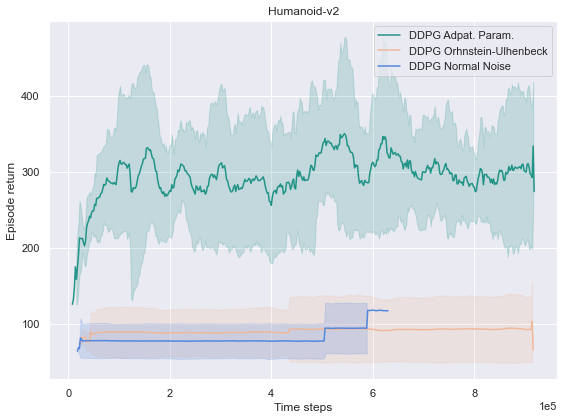

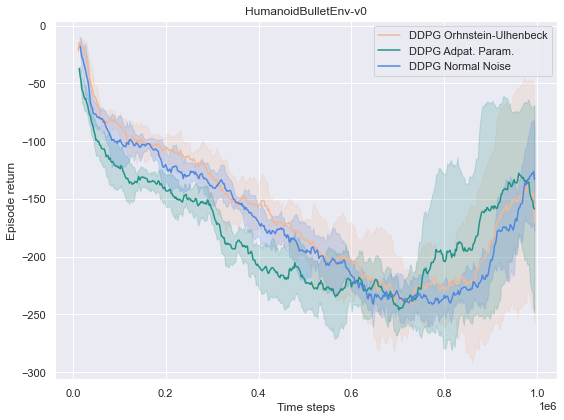

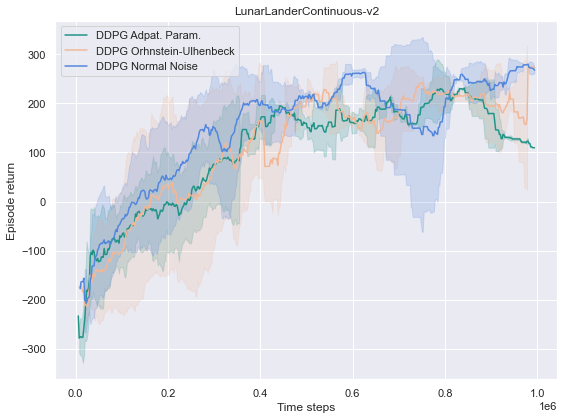

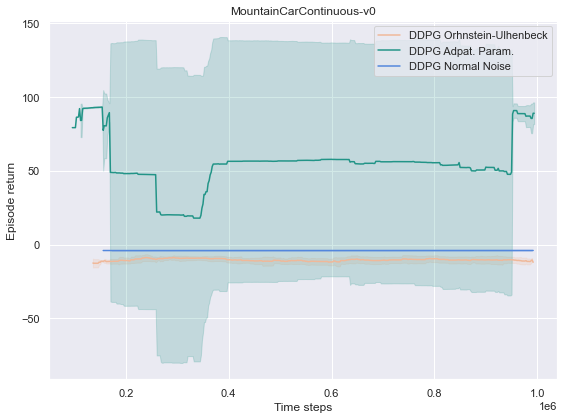

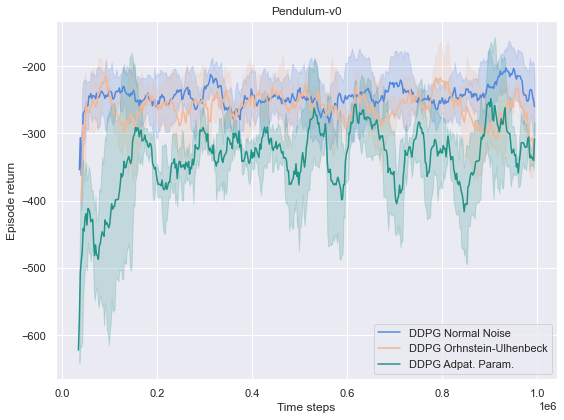

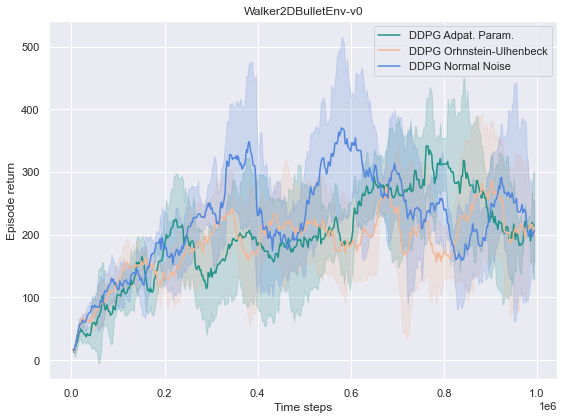

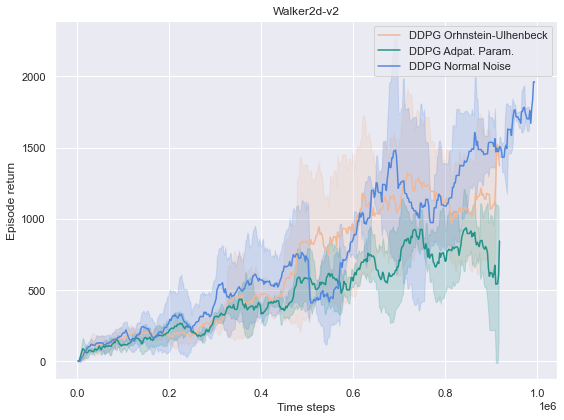

In [78]:
# Generates plots for all the environments
for env_name in ALL_ENVS:
    env_df = env_df = ALL_ENV_EPISODE_RETURN_DF[env_name]
    
    # Plot parameterization
    fig, ax = plt.subplots(figsize=(8,6))

    # Plot the data onto the ax object
    sns.lineplot(data=env_df,
        x="global_step",
        y="eval/train_episode_return",
        ci='sd', ax=ax, hue="algo",
        palette=current_palette_dict
    )
    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend(handles=handles[1:], labels=labels[1:])
    labels = [label_to_readable[label] for label in labels[1:]]

    # Plot config and pretify
    ax.set_title(env_name)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Episode return")
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
    ax.legend(handles[1:], labels)

    plt.tight_layout()

    plt.show()
    fig.savefig(f"{env_name}_EpisodeReturn_NoiseType.png")